# 02. Exploratory Data Analysis (EDA)

## Objective
- Phân tích hành vi tiêu thụ điện
- Phát hiện các mô hình thời vụ

## 1. Setup and Load Dataset

In [ ]:
# Core (in requirements.txt)
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Add the root directory to the path so Python can find the 'src' module
import os
import sys
sys.path.append(os.path.abspath('../'))
from src.data_loader import load_raw_data

# Display configuration
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Check Python version (Requires 3.10.11 as specified in .python-version)
print(f"Python version: {sys.version}")

In [ ]:
# Call the function from src/data_loader.py
try:
    df = load_raw_data()
except Exception as e:
    print(f"❌ Error: {e}")

❌ Error: name 'load_raw_data' is not defined


## 2. Time Series Visualization
- Chuỗi thời gian tổng
- Chuỗi theo consumer (mẫu đại diện)

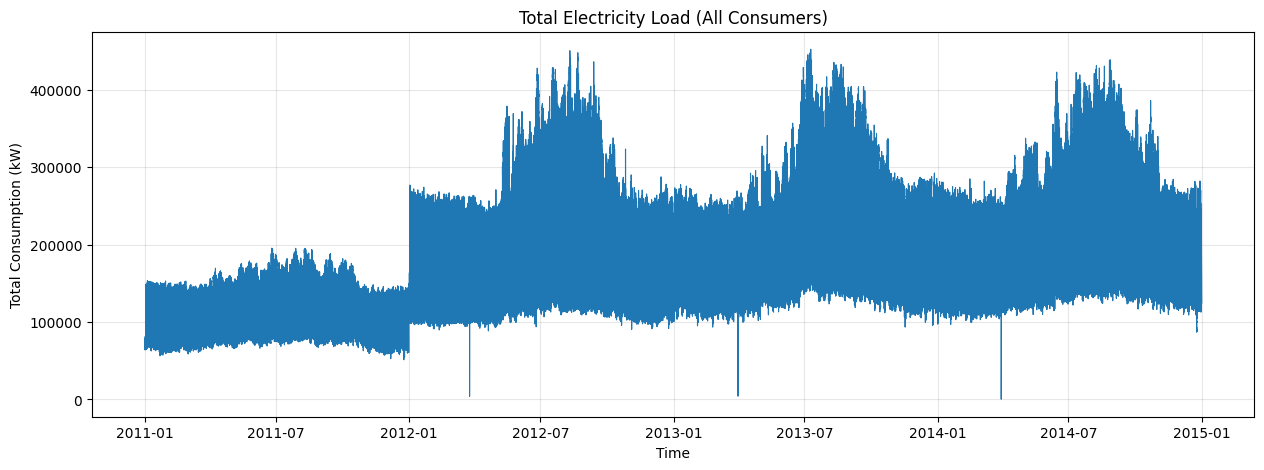

In [ ]:
# chuỗi thời gian theo tổng 

df_total = df.sum(axis=1)
plt.figure(figsize=(15, 5))
plt.plot(df_total, linewidth=0.8)
plt.title("Total Electricity Load (All Consumers)")
plt.xlabel("Time")
plt.ylabel("Total Consumption (kW)")
plt.grid(alpha=0.3)
plt.show()

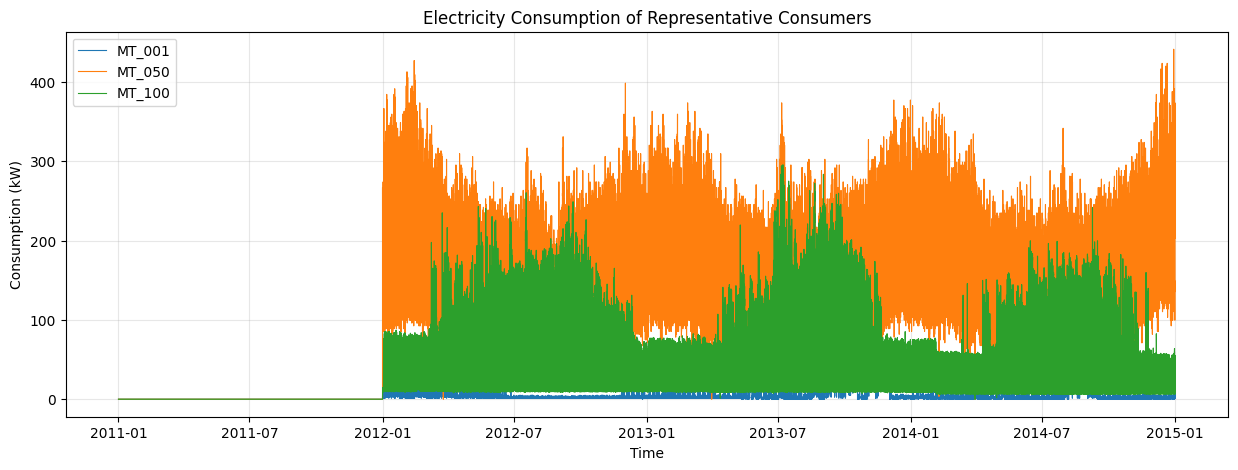

In [ ]:
# chuỗi theo consumer
sample_consumers = ["MT_001", "MT_050", "MT_100"]
plt.figure(figsize=(15, 5))
for c in sample_consumers:
    plt.plot(df[c], label=c, linewidth=0.8)

plt.title("Electricity Consumption of Representative Consumers")
plt.xlabel("Time")
plt.ylabel("Consumption (kW)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 3. Seasonality Analysis
### 3.1 Daily Seasonality
- Biểu đồ trung bình theo giờ

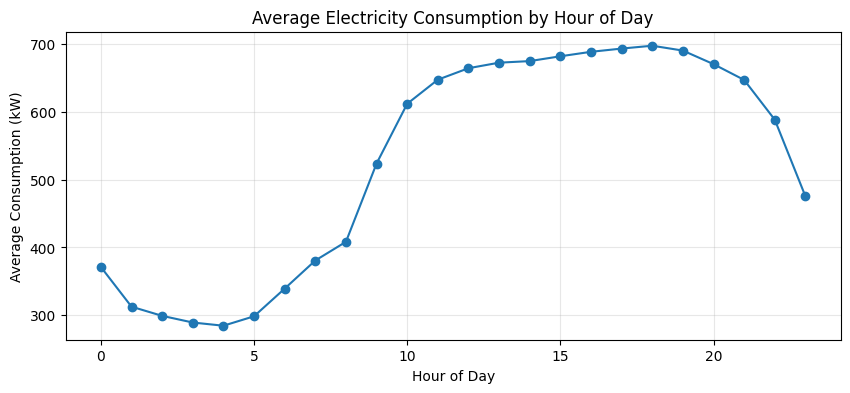

In [ ]:
# chuẩn bị feature
df_time = df.copy()
df_time["hour"] = df_time.index.hour
df_time["dayofweek"] = df_time.index.dayofweek
df_time["month"] = df_time.index.month
# trung bình theo giờ
daily_avg = df_time.groupby("hour").mean().mean(axis=1)
plt.figure(figsize=(10, 4))
plt.plot(daily_avg, marker="o")
plt.title("Average Electricity Consumption by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Consumption (kW)")
plt.grid(alpha=0.3)
plt.show()

### 3.2 Weekly Seasonality
- Ngày trong tuần vs cuối tuần

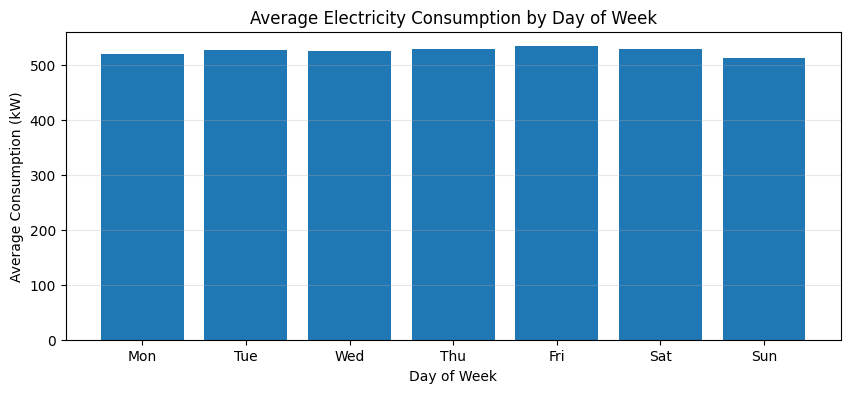

In [ ]:
# theo tuần
weekly_avg = df_time.groupby("dayofweek").mean().mean(axis=1)
plt.figure(figsize=(10, 4))
plt.bar(
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    weekly_avg
)
plt.title("Average Electricity Consumption by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Consumption (kW)")
plt.grid(axis="y", alpha=0.3)
plt.show()


### 3.3 Yearly Seasonality
- Biến động theo tháng / mùa

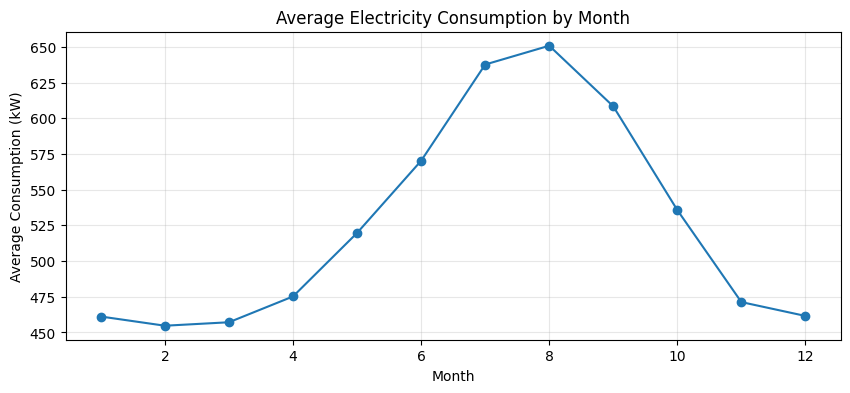

In [ ]:
# theo tháng
monthly_avg = df_time.groupby("month").mean().mean(axis=1)
plt.figure(figsize=(10, 4))
plt.plot(monthly_avg, marker="o")
plt.title("Average Electricity Consumption by Month")
plt.xlabel("Month")
plt.ylabel("Average Consumption (kW)")
plt.grid(alpha=0.3)
plt.show()


## 4. Load Distribution
- Histogram
- Boxplot

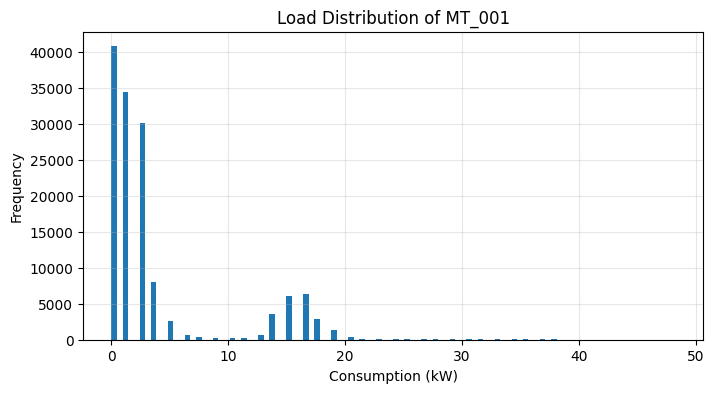

In [ ]:
# histogram
sample_client = "MT_001"
plt.figure(figsize=(8, 4))
plt.hist(df[sample_client], bins=100)
plt.title(f"Load Distribution of {sample_client}")
plt.xlabel("Consumption (kW)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

C:\Users\XPS\AppData\Local\Temp\ipykernel_22016\254991920.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=box_data.columns, showfliers=True)


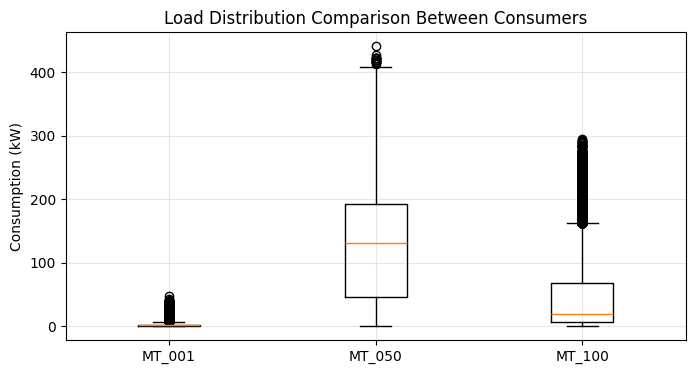

In [ ]:
#boxplot
box_data = df[["MT_001", "MT_050", "MT_100"]]
plt.figure(figsize=(8, 4))
plt.boxplot(box_data, labels=box_data.columns, showfliers=True)
plt.title("Load Distribution Comparison Between Consumers")
plt.ylabel("Consumption (kW)")
plt.grid(alpha=0.3)
plt.show()


## 5. Statistical Summary
- Mean, Median, Std
- Min / Max

In [ ]:
# Statistical Summary
stats = df.describe().T[["mean", "50%", "std", "min", "max"]]
stats.columns = ["Mean", "Median", "Std", "Min", "Max"]
stats.head(10)


,Mean,Median,Std,Min,Max
MT_001,3.970785,1.269036,5.983965,0.0,48.223350
MT_002,20.768480,24.893314,13.272415,0.0,115.220484
MT_003,2.918308,1.737619,11.014456,0.0,151.172893
MT_004,82.184490,87.398374,58.248392,0.0,321.138211
MT_005,37.240309,39.024390,26.461327,0.0,150.000000
MT_006,141.227385,157.738095,98.439984,0.0,535.714286
MT_007,4.521338,2.826456,6.485684,0.0,44.657999
MT_008,191.401476,222.222222,121.981187,0.0,552.188552
MT_009,39.975354,40.209790,29.814595,0.0,157.342657
MT_010,42.205152,40.860215,33.401251,0.0,198.924731


## 6. Key Insights
- Các mẫu thời vụ quan trọng
- Nhận dạng giờ cao điểm / thấp điểm

In [ ]:
# xác định giờ cao điểm, thấp điểm
peak_hour = daily_avg.idxmax()
offpeak_hour = daily_avg.idxmin()
print(f"Peak hour: {peak_hour}:00")
print(f"Off-peak hour: {offpeak_hour}:00")
# tỷ lệ zero load
zero_ratio = (df == 0).sum().sum() / df.size
print(f"Zero-load ratio: {zero_ratio:.2%}")

Peak hour: 18:00
Off-peak hour: 4:00
Zero-load ratio: 20.15%


## 7. Conclusion
- Tóm tắt insight chính phục vụ modeling